In [1]:
from yahoo_historical import Fetcher
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

Using TensorFlow backend.


In [2]:
from IPython.display import HTML, display
import tabulate
def extract_data(tickers):
    """
    Extract data from yahoo finance for any given ticker from 2009 to 2019.
    
    Parameters
    ----------
    tickers: list of ticker symbols
    
    Returns
    -------
    dfs: list of dataframes containing the Open, High, 
         Low, Close, Adj Close and Volume for each ticker
         for the duration mentioned above.
    """
    dfs = []
    for t in tickers:
        print (t)
        data = Fetcher(t, [2009,1,1], [2019,1,1])
        data = data.getHistorical()
        data["Date"] = pd.to_datetime(data["Date"])
        #data = data[["Adj Close", "Date"]]
        data = data.set_index('Date').dropna(axis=1)
        display(HTML(tabulate.tabulate(data.describe(), tablefmt='html')))
        dfs.append(data)
    return dfs

In [3]:
def get_features_target(df, days_in_future):
    """
    Split the data into Features and Target Dataframes.
    Target is the Adj Closing price -- x days in the future.
    
    Parameters
    ----------
    df: Data frame to split into target and features
    days_in_future: The number of days
                    in the future you want to predict prices for.
    Returns
    -------
    features: dataframe of features to be used to train the model.
    target: dataframe of the target values that the model wants to predict.
    """
    target = df[["Adj Close"]][days_in_future:]
    features = df
    features = features.shift(days_in_future).dropna()
    return features, target

In [4]:
def min_max_scale_features(input_features):
    """
    Apply Scikit Learn's Min-Max Scaler to the input data.
    Parameters
    ----------
    input_features: input dataframe to scale
    
    Returns
    -------
    output_features: Scaled dataframe 
    """
    min_max_scaler = MinMaxScaler()
    output_features = pd.DataFrame(min_max_scaler.fit_transform(input_features),
                            columns=input_features.columns,
                            index=input_features.index)
    return output_features

def mean_scale_features(input_features):
    """
    This scaling is a customized scaling where I:
    1) subtract the mean of the dataset.
    2) divide by the standard deviation of the mean subtracted dataset.
    Parameters
    ----------
    input_features: input dataframe to scale
    
    Returns
    -------
    scaled_input_features: Scaled dataframe
    scaled_means: Dataframe of the mean values that were subtracted
    scaled_stds: Dataframe of the standard deviation calculated for the input array.
                 The scaled_means and scaled_stds can be used to unscale the data.
    """
    scaled_means = input_features.mean(axis=0)
    scaled_input_features = input_features.subtract(input_features.mean(axis=0), axis=1)
    scaled_stds = scaled_input_features.std(axis=0)
    scaled_input_features = scaled_input_features.divide(scaled_input_features.std(axis=0), axis=1)
    return scaled_input_features, scaled_means, scaled_stds

def unscale_target(input_target, scaled_mean, scaled_stds):
    """
    Unscale the data to original levels using the standard deviation and mean 
    statistics from the original dataset. The scaled_mean and scaled_stds will
    be used to unscale the data.
    
    Parameters
    ----------
    input_target: input array to unscale back to the original levels.
    scaled_mean: mean value that was subtracted from the original dataset
    scaled_stds: standard deviation calculated for the original dataset.
    
    Returns
    -------
    input_target: unscaled array
    """
    input_target = input_target*scaled_stds
    input_target += scaled_mean
    return input_target

In [5]:
def split_train_test(features, target, split_date = '2017-05-31'):
    """
    Split the features and target into training and testing sets.
    
    Parameters
    ----------
    features: dataframe of feature values
    target: dataframe of target values
    split_date: the date about which we want to split the data.
    
    Returns
    -------
    features_train: training set of features
    features_test: testing set of features.
    target_train: training set of target values. 
    target_test: testing set of target values.
    """
    features_train = features[features.index <= split_date]
    features_test = features[features.index > split_date]
    target_train = target[target.index <= split_date]
    target_test = target[target.index > split_date]
    return features_train, features_test, target_train, target_test

In [6]:
def make_features_array(df):
    """
    Generate an array from features dataframe to be used by the LSTM model.
    
    Parameters
    ----------
    df: dataframe to convert to array
    
    Yields
    ------
    data_array
    """
    data_array = df.values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-1), range(1, num_elements)):
        yield data_array[start:stop, :]

In [7]:
def make_target_array(df):
    """
    Generate an array from target dataframe.
    
    Parameters
    ----------
    df: dataframe to convert to array
    
    Returns
    ------
    data_array
    """
    data_array = df.values
    num_elements = data_array.shape[0]
    return data_array[1:num_elements]

In [8]:
def explore_data(dfs, tickers):
    """
    plot the Adj Closing prices of each ticker
    as a subplot.
    
    Parameters
    ----------
    dfs: list of dataframes to explore
    tickers: list of ticker labels.

    """
    figure = plt.figure(figsize=(15, 15))
    figure.suptitle("Adj Close Prices Exploration", fontsize=24)
    for i, df in enumerate(dfs):
        plt.subplot(len(dfs)//2+1, 2, i+1)
        df['Adj Close'].plot(color='black')
        plt.ylabel(tickers[i])
        plt.grid()
    plt.show()

In [9]:
def plot_values(output):
    """
    plot the predicted and actual target values "Adj closing prices"
    as a subplot for each ticker.
    
    Parameters
    ----------
    output: dictionary of each ticker's predicted and actual target values.
    """
    figure = plt.figure(figsize=(15, 10))
    figure.suptitle("Comparing Predicted to Actual Adj Close Prices", fontsize=24)
    for i, ticker in enumerate(list(output.keys())):
        plt.subplot(len(output)//2+1, 2, i+1)
        plt.plot(output[ticker][0], label='Predicted Adj Close')
        plt.plot(output[ticker][1], label='Actual Adj Close')
        plt.title(ticker)
        plt.ylabel("Adj Close Price")
        plt.legend()
        plt.grid()
        plt.axis('tight')
    plt.show()

In [10]:
def plot_diff(output):
    """
    plot the predicted and actual target values "Adj closing prices"
    as a subplot for each ticker.
    
    Parameters
    ----------
    output: dictionary of each ticker's predicted and actual target values.
    """
    figure = plt.figure(figsize=(15, 10))
    figure.suptitle("Percentage Adj Close Price difference between predicted and original values", fontsize=24)
    for i, ticker in enumerate(list(output.keys())):
        plt.subplot(len(output)//2+1, 2, i+1)
        plt.plot(100*(output[ticker][0] - output[ticker][1]) / output[ticker][1])
        #plt.plot(output[ticker][1], label='Actual Adj Close')
        plt.title(ticker)
        plt.ylabel("Adj Close Price Difference Percentage")
        plt.grid()
        plt.axis('tight')
    plt.show()

In [11]:
def plot_history(histories):
    """
    Plot the learning history as a function of epoch for 
    each ticker as a subplot.
    
    Parameters
    ----------
    histories: dictionary of learning history for each ticker.
    """
    figure = plt.figure(figsize=(15, 10))
    figure.suptitle("Learning History", fontsize=24)
    for i, ticker in enumerate(list(histories.keys())):
        plt.subplot(len(histories)//2+1, 2, i+1)
        plt.plot(histories[ticker].history['loss'], label='train')
        plt.plot(histories[ticker].history['val_loss'], label='valid')
        plt.ylabel(ticker)
        plt.xlabel('Epoch')
        plt.legend()
    plt.show()

In [12]:
def evaluate(prediction_values, target_test_values):
    """
    Compute the R2 score and the square root of the Mean Squared Error.
    This is used to evaluate the performance of the models.
    
    Parameters
    ----------
    prediction_values: array of predicted values
    target_test_values: array of actual target values
    
    Returns
    -------
    r2_score and Mean squared Error
    """
    return r2_score(target_test_values,prediction_values), np.sqrt(mean_squared_error(target_test_values,prediction_values))

# Benchmark Model (Linear Regression)

In [13]:
def run_linear_regression_model(dfs, tickers):
    """
    Run the benchmark model: Linear Regression.
    """
    output = {}
    for i, df in enumerate(dfs):
        # Extract features and target varaiables
        features, target = get_features_target(df, days_in_future=1)
        # split into test and training sets
        features_train, features_test, target_train, target_test = split_train_test(features, target)
       
        target_train_array = target_train["Adj Close"].tolist()
        features_train_array = list(range(len(target_train_array)))
        target_test_array = target_test["Adj Close"].tolist()
        features_test_array = list(range(len(target_train_array), len(target_test_array)+len(target_train_array)))
        
        # convert dataframes into arrays
        features_train_array = np.reshape(features_train_array, (len(features_train_array), 1))
        target_train_array = np.reshape(target_train_array, (len(target_train_array), 1))
        features_test_array = np.reshape(features_test_array, (len(features_test_array), 1))
        target_test_array = np.reshape(target_test_array, (len(target_test_array), 1))
 
        # make Scikit Learn's Linear Regression Model
        linear_model = LinearRegression()
        # Fit the model to the training set
        linear_model.fit(features_train_array, target_train_array)
        # Use the model to predict the results in the testing set
        linear_prediction = linear_model.predict(features_test_array)
        # Evaluate the model
        r2, mse = evaluate(linear_prediction, target_test_array)
        print (tickers[i], ': R2 score: ', r2, ', Mean Square Error: ',mse)
        #save the output to a dictionary for plotting
        output[tickers[i]] = (linear_prediction, target_test_array)
    #plot the output
    plot_values(output)

# LSTM Model (RNN)

In [14]:
def lstm_model(num_features=6, dropout_rate=0.5, activation='linear', optimizer='nadam'):
    """
    Make and compile the LSTM model that will be used to learn from
    the training set and applied to the testing set.
    The model consists of 1 LSTM layer with 128 units followed by a
    Dropout layer, a Dense Layer and an activation layer with a linear 
    activiation finction. The model is compiled using the mean squared 
    error as a loss function and nadam as the optimizer.

    Parameters
    ----------
    num_features: number of features in the features array
    dropout_rate: the dropout rate (Default: 0.5)
    activation: activation function to apply (Default: 'linear')
    optimizer: optimizer to use while compiling (Default: 'nadam')
    
    Returns
    -------
    model: A compiled LSTM model that can be used for fitting and prediction.
    """
    model = Sequential()
    model.add(LSTM(
             input_shape=(1, num_features),
             units=128))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.add(Activation(activation))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [15]:
def tune_hyperparameters(param_grid, features_train_array, target_train_array):
    """
    Tune hyperparameters and find the best parameters that fit the data.
    Parameters
    ----------
    param_grid: dict of hyperparameters to tune
    features_train_array: array of features to fit the parameters to.
    target_train_array: array of target values.
    
    Returns
    -------
    best_params: dict of best parameters from the parameter grid
    """
    model = KerasRegressor(build_fn=lstm_model, verbose=0)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
    grid_result = grid.fit(features_train_array, target_train_array)
    best_params = grid_result.best_params_
    print("Best Score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    return best_params

In [16]:
def run_lstm_model(dfs, tickers):
    """
    Run the LSTM Model.
    """
    output = {}
    histories = {}
    batch_size = [10, 30]
    epochs = [20, 50]
    activation = ['linear']
    optimizer = ['adam', 'nadam']
    param_grid = dict(batch_size=batch_size,
                      epochs=epochs,
                      activation=activation,
                      optimizer=optimizer)
    for i, df in enumerate(dfs):
        # Extract features and target varaiables
        features, target = get_features_target(df, days_in_future=1)
        # split into test and training sets
        features_train, features_test, target_train, target_test = split_train_test(features, target)
        # Scale the data both training and testing
        features_train, scaled_mean_features_train, scaled_stds_features_train = mean_scale_features(features_train)
        target_train, scaled_mean_target_train, scaled_stds_target_train = mean_scale_features(target_train)
        features_test, scaled_mean_features_test, scaled_stds_features_test = mean_scale_features(features_test)
        target_test, scaled_mean_target_test, scaled_stds_target_test = mean_scale_features(target_test)

        # convert dataframes into arrays
        features_train_array = np.array(list(make_features_array(features_train)))
        features_test_array = np.array(list(make_features_array(features_test)))
        target_train_array = np.array(list(make_target_array(target_train)))
        target_test_array = np.array(list(make_target_array(target_test)))
 
        # build the Deep Neural Network
        num_features = features_train_array.shape[2]
        
        # Tune the hyperparameters
        if i == 0:
            best_params = tune_hyperparameters(param_grid, 
                                               features_train_array, 
                                               target_train_array)
        
        # make the model using the the best set of hyperparameters   
        best_model = lstm_model(num_features=num_features,
                           activation=best_params['activation'],
                           optimizer=best_params['optimizer'])
        if i == 0: best_model.summary()
        # Fit the data
        history = best_model.fit(features_train_array,
                            target_train_array,
                            epochs=best_params['epochs'],
                            batch_size=best_params['batch_size'],
                            validation_split=0.05,
                            verbose=0)
        #save the learning history over epochs
        histories[tickers[i]] = history
        # use the model to pedict the output for the training set
        lstm_prediction = best_model.predict(features_test_array, 
                                             batch_size=best_params['batch_size'])
        # since the output will be scaled, unscale it to the original levels
        lstm_prediction = unscale_target(lstm_prediction, 
                                         scaled_mean_target_test['Adj Close'], 
                                         scaled_stds_target_test['Adj Close'])
        target_test_array = unscale_target(target_test_array, 
                                           scaled_mean_target_test['Adj Close'], 
                                           scaled_stds_target_test['Adj Close'])

        #Evaluate the model
        r2, mse = evaluate(lstm_prediction, target_test_array)
        print (tickers[i], ': R2 score: ', r2, ', Mean Square Error: ',mse)
        output[tickers[i]] = (lstm_prediction, target_test_array)

    plot_history(histories)
    plot_values(output)
    plot_diff(output)

In [17]:
%matplotlib inline
def main():
    seed = 7
    np.random.seed(seed)
    tickers = ['AAPL', 'GOOGL', 'AMZN', 'NVDA', 'MSFT']
    dfs = extract_data(tickers)
    explore_data(dfs, tickers)
    run_linear_regression_model(dfs, tickers)
    run_lstm_model(dfs, tickers)

AAPL


count,2516,2516,2516,2516,2516,2516
mean,91.5972,92.4069,90.7341,91.5873,85.4103,8.6325e+07
std,50.2748,50.6859,49.8551,50.2726,50.3187,6.1923e+07
min,11.3414,11.7143,11.1714,11.1714,9.74945,1.14759e+07
25%,51.0336,51.4179,50.555,50.9639,44.4769,3.69977e+07
50%,85.7893,86.6857,84.9764,86.1071,75.7696,7.09382e+07
75%,118.92,119.875,118.212,119.145,112.134,1.1645e+08
max,230.78,233.47,229.78,232.07,228.524,4.7025e+08


GOOGL


count,2516,2516,2516,2516,2516,2516
mean,554.972,559.659,549.823,554.842,554.842,3.9364e+06
std,296.359,298.913,293.517,296.245,296.245,2.99744e+06
min,144.319,149.9,141.517,141.517,141.517,520600
25%,295.262,297.047,292.101,295.116,295.116,1.74285e+06
50%,523.825,530.525,518.295,522.975,522.975,3.278e+06
75%,770.337,777.843,764.172,770.065,770.065,5.10105e+06
max,1289.12,1291.44,1263,1285.5,1285.5,2.96199e+07


AMZN


count,2516,2516,2516,2516,2516,2516
mean,505.953,511.113,499.909,505.746,505.746,4.99449e+06
std,467.136,471.579,461.101,466.377,466.377,3.44577e+06
min,48.56,50.1,47.63,48.44,48.44,984400
25%,185.735,188.403,183.563,185.818,185.818,2.90415e+06
50%,309.045,312.69,305.155,309.845,309.845,4.1317e+06
75%,726.425,729.67,719.845,726.96,726.96,5.9841e+06
max,2038.11,2050.5,2013,2039.51,2039.51,5.83058e+07


NVDA


count,2516,2516,2516,2516,2516,2516
mean,54.7694,55.5706,53.8663,54.7438,53.8381,1.38323e+07
std,73.8333,74.8638,72.5991,73.7494,73.7429,9.06445e+06
min,7.21,7.47,7.08,7.21,6.65138,1.1411e+06
25%,13.9075,14.1125,13.6275,13.87,12.8231,7.80108e+06
50%,18.29,18.56,18.085,18.285,17.2834,1.15222e+07
75%,47.505,47.9,47.1625,47.5525,46.9767,1.73908e+07
max,289.32,292.76,285.58,289.36,288.444,9.23232e+07


MSFT


count,2516,2516,2516,2516,2516,2516
mean,45.5529,45.9534,45.1356,45.5646,41.4448,4.37174e+07
std,23.9477,24.1402,23.6991,23.9257,24.919,2.47416e+07
min,15.2,15.62,14.87,15.15,11.7711,7.4256e+06
25%,27.6375,27.915,27.3275,27.6275,22.653,2.6765e+07
50%,37.23,37.54,36.9,37.21,32.5864,3.82786e+07
75%,55.57,55.9775,55.095,55.6775,51.6542,5.42348e+07
max,115.42,116.18,114.93,115.61,113.821,3.19318e+08


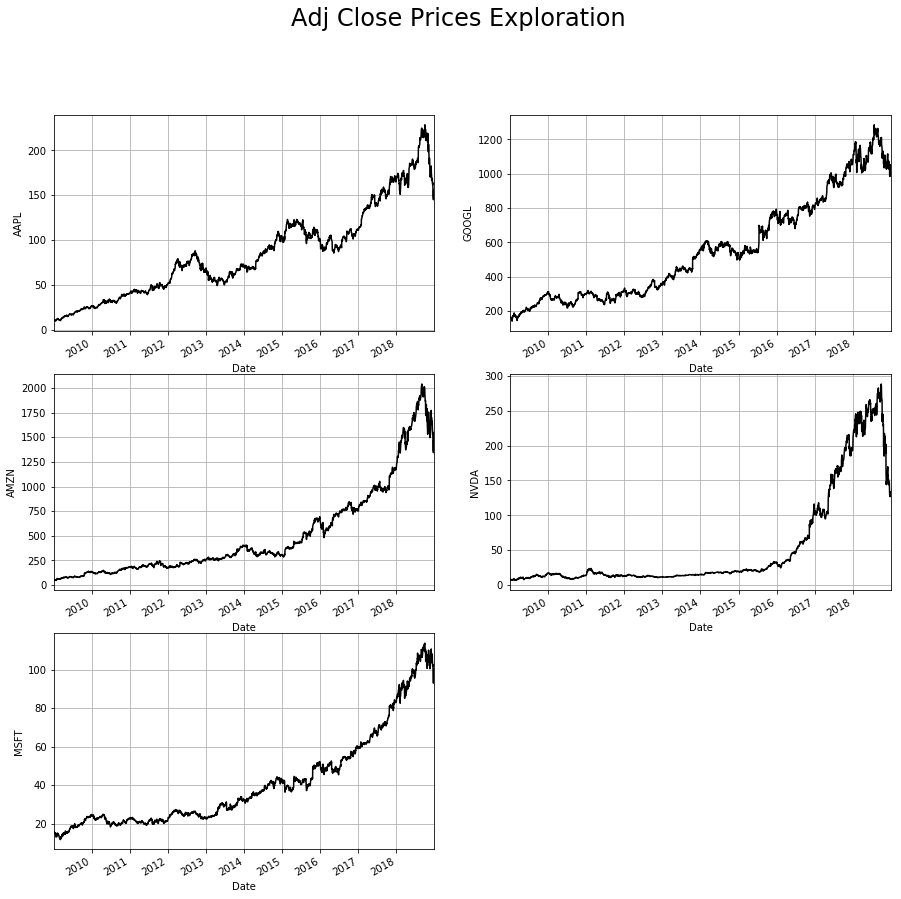

AAPL : R2 score:  -2.56287209982 , Mean Square Error:  43.4298800888
GOOGL : R2 score:  -4.99054412757 , Mean Square Error:  219.075335817
AMZN : R2 score:  -3.59015930696 , Mean Square Error:  720.119868027
NVDA : R2 score:  -13.9705382656 , Mean Square Error:  158.757250998
MSFT : R2 score:  -4.73631784175 , Mean Square Error:  33.9609792838


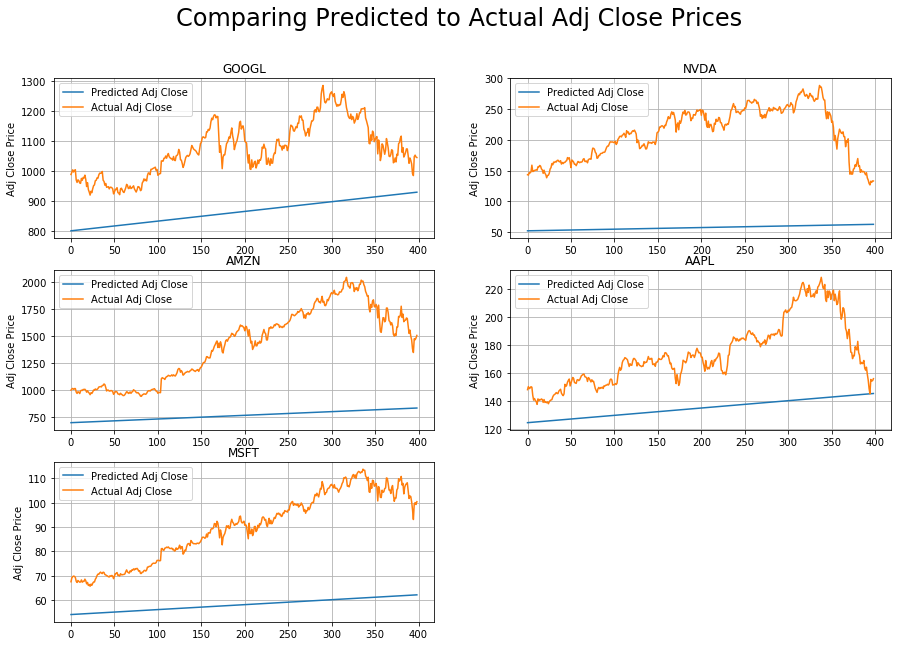

Best Score: 0.040654 using {'batch_size': 30, 'activation': 'linear', 'optimizer': 'adam', 'epochs': 20}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               69120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 69,249.0
Trainable params: 69,249.0
Non-trainable params: 0.0
_________________________________________________________________
AAPL : R2 score:  0.965037371797 , Mean Square Error:  4.30069659658
GOOGL : R2 score:  0.930335724961 , Mean Square Error:  23.6281113496
AMZN : R2 score:  0.

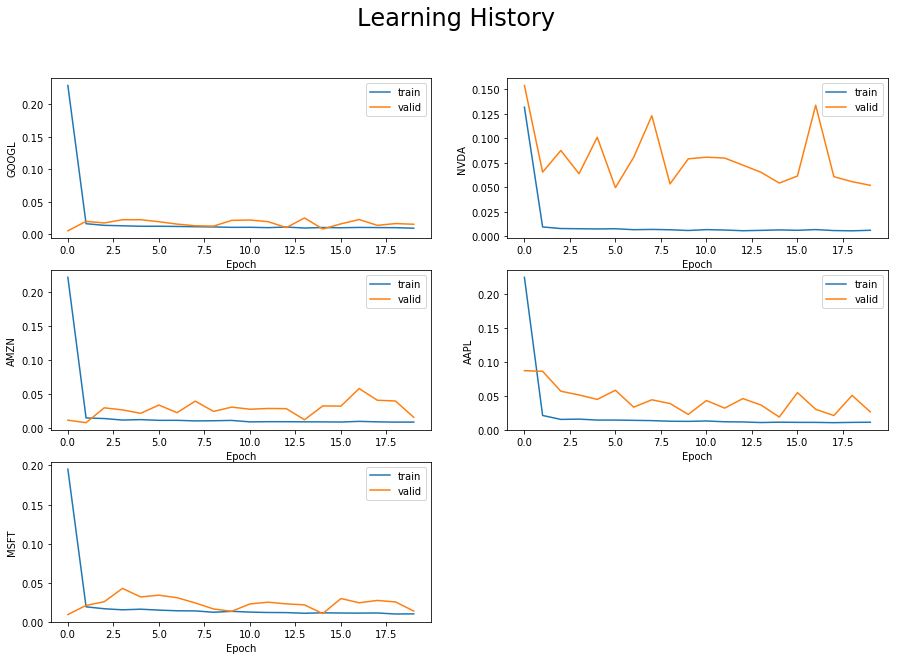

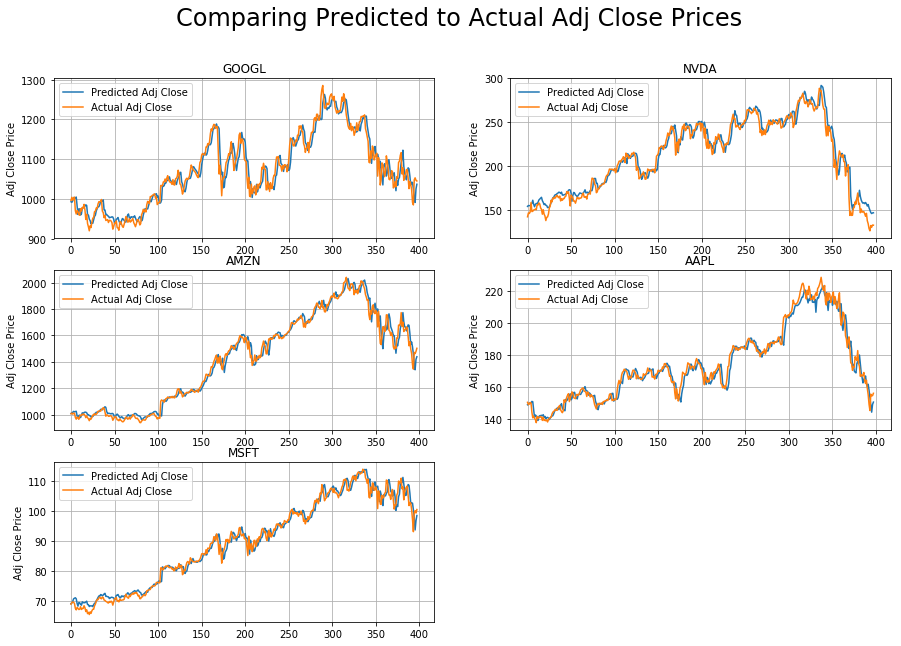

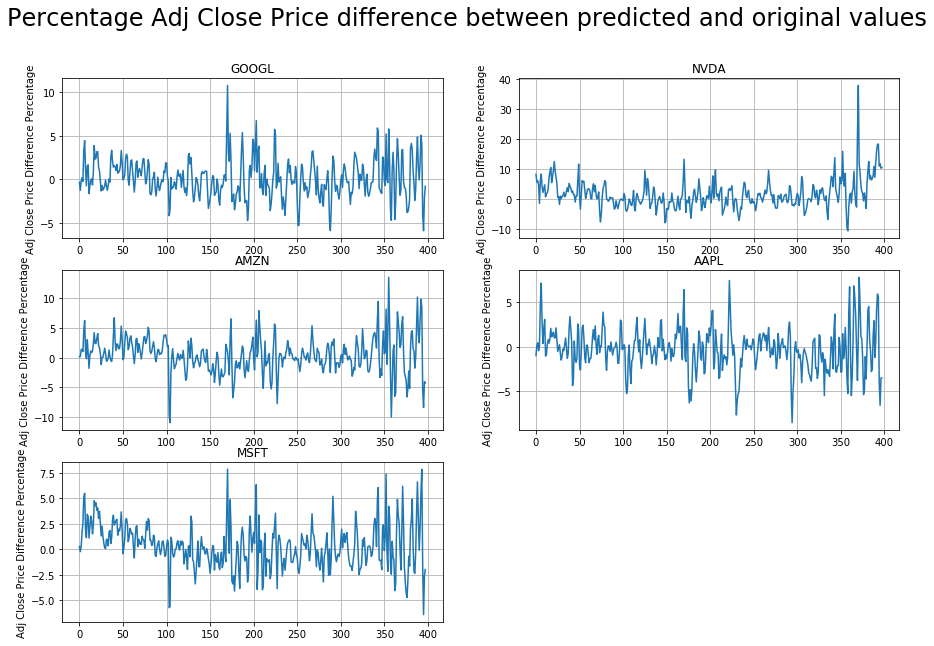

In [18]:
main()